<a href="https://colab.research.google.com/github/vneumannufprbr/TrabajosenPython/blob/main/SenPredicSTXGBoostPresaOk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Re-run the initial setup including installation and imports

# 0. Fijar semillas aleatorias para reproducibilidad
import os
import random
import numpy as np
import tensorflow as tf # Mantener la importación de tensorflow para set_all_seeds, pero no las capas/modelos de Keras
import pandas as pd # Importar pandas aquí también
from sklearn.preprocessing import MinMaxScaler # Importar MinMaxScaler
from sklearn.model_selection import train_test_split # Importar train_test_split
import matplotlib.pyplot as plt # Importar matplotlib
import matplotlib.dates as mdates # Importar mdates

def set_all_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    # Para versiones más recientes de TensorFlow, también podrías necesitar:
    # tf.keras.utils.set_random_seed(seed)

set_all_seeds()

# 1. Instalación de librerías
!pip install keras-tuner -q


# 2. Importación de librerías necesarias (Keras Tuner se instala arriba)
import keras_tuner as kt


# 3. Carga y preparación de datos
try:
    df = pd.read_excel('/content/datos_fusionados_operantes.xlsx')
except FileNotFoundError:
    print("Error: Asegúrate de que el archivo 'datos_fusionados_operantes.xlsx' se haya cargado en tu entorno de Colab.")
    df = pd.DataFrame()

if not df.empty:
    # Seleccionar el sensor para el ejemplo (usar la misma variable sensor_tag si ya está definida, o definirla)
    # Asegurarse de que sensor_tag esté definida o definir un valor por defecto
    if 'sensor_tag' not in locals():
        sensor_tag = 'PS-E-023/2 | (MCA)' # Definir un valor por defecto si no existe

    df_sensor = df[df['nombre_etiqueta'] == sensor_tag].copy()

    # Comprobar si df_sensor está vacío
    if df_sensor.empty:
        print(f"Error: No se encontraron datos para la etiqueta de sensor '{sensor_tag}'. Por favor, verifica la etiqueta del sensor y los datos.")
    else:
        df_sensor['fecha'] = pd.to_datetime(df_sensor['fecha'])
        df_sensor = df_sensor.sort_values('fecha').set_index('fecha')

        # 4. Escalado de datos
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = scaler.fit_transform(df_sensor[['valor_promedio']])

        # Comprobar si hay valores NaN o infinitos en los datos escalados
        if np.isnan(scaled_data).any() or np.isinf(scaled_data).any():
            print("Error: Los datos escalados contienen valores NaN o infinitos. Por favor, verifica tus datos y el proceso de escalado.")
        else:
            # Usaremos un enfoque de ventana deslizante para crear características a partir de valores pasados

            def create_features_xgb(data, sequence_length):
                X, y = [], []
                for i in range(len(data) - sequence_length):
                    # Crear características a partir de la ventana deslizante (valores pasados)
                    features = data[i:(i + sequence_length), 0]
                    X.append(features)
                    # El valor objetivo es el siguiente valor después de la ventana
                    y.append(data[i + sequence_length, 0])
                return np.array(X), np.array(y)

            # Usar la misma sequence_length definida previamente, o definirla si no existe
            if 'sequence_length' not in locals():
                 sequence_length = 6 # Definir un valor por defecto si no existe

            # Preparar los datos escalados para XGBoost
            X_xgb, y_xgb = create_features_xgb(scaled_data, sequence_length)

            # Comprobar si hay valores NaN o infinitos en las secuencias generadas (X_xgb y y_xgb)
            if np.isnan(X_xgb).any() or np.isinf(X_xgb).any():
                 print("Error: Los datos preparados para XGBoost (X_xgb) contienen valores NaN o infinitos. Por favor, verifica tus datos.")
            elif np.isnan(y_xgb).any() or np.isinf(y_xgb).any():
                 print("Error: Los datos preparados para XGBoost (y_xgb) contienen valores NaN o infinitos. Por favor, verifica tus datos.")
            else:
                # División de datos (cronológica) para XGBoost
                split_point_xgb = int(len(X_xgb) * 0.8)
                X_train_xgb, X_test_xgb = X_xgb[:split_point_xgb], X_xgb[split_point_xgb:]
                y_train_xgb, y_test_xgb = y_xgb[:split_point_xgb], y_xgb[split_point_xgb:]

                # Comprobar si hay valores NaN o infinitos en los conjuntos de entrenamiento/prueba para XGBoost
                if np.isnan(X_train_xgb).any() or np.isinf(X_train_xgb).any() or \
                   np.isnan(X_test_xgb).any() or np.isinf(X_test_xgb).any() or \
                   np.isnan(y_train_xgb).any() or np.isinf(y_train_xgb).any() or \
                   np.isnan(y_test_xgb).any() or np.isinf(y_test_xgb).any():
                    print("Error: Los conjuntos de entrenamiento o prueba para XGBoost contienen valores NaN o infinitos. Por favor, verifica tus datos.")
                else:
                    print("Datos preparados para XGBoost y divididos exitosamente.")
                    print(f"Forma de X_train_xgb: {X_train_xgb.shape}")
                    print(f"Forma de y_train_xgb: {y_train_xgb.shape}")
                    print(f"Forma de X_test_xgb: {X_test_xgb.shape}")
                    print(f"Forma de y_test_xgb: {y_test_xgb.shape}")

Datos preparados para XGBoost y divididos exitosamente.
Forma de X_train_xgb: (1128, 6)
Forma de y_train_xgb: (1128,)
Forma de X_test_xgb: (282, 6)
Forma de y_test_xgb: (282,)


Generar múltiples predicciones futuras utilizando el modelo entrenado, visualizar las predicciones junto con los datos históricos y guardar el modelo entrenado.

Se requiere generar múltiples predicciones futuras de forma iterativa utilizando el modelo entrenado. Esto implica tomar la última secuencia de datos históricos, predecir el siguiente paso, añadirlo a la lista de predicciones y luego usar esta nueva secuencia como entrada para la siguiente predicción. Este proceso debe repetirse para el número deseado de pasos futuros. El bloque de código definirá el número de pasos futuros, inicializará la lista de predicciones y la secuencia de entrada, y luego realizará un bucle para generar las predicciones y actualizar la secuencia de entrada. Finalmente, des-escalará las predicciones escaladas.

In [3]:
# Preparación de datos para XGBoost
# Usaremos un enfoque de ventana deslizante para crear características a partir de valores pasados

def create_features_xgb(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        # Crear características a partir de la ventana deslizante (valores pasados)
        features = data[i:(i + sequence_length), 0]
        X.append(features)
        # El valor objetivo es el siguiente valor después de la ventana
        y.append(data[i + sequence_length, 0])
    return np.array(X), np.array(y)

# Preparar los datos escalados para XGBoost
X_xgb, y_xgb = create_features_xgb(scaled_data, sequence_length)

# Comprobar si hay valores NaN o infinitos en los datos preparados para XGBoost
if np.isnan(X_xgb).any() or np.isinf(X_xgb).any():
     print("Error: Los datos preparados para XGBoost (X_xgb) contienen valores NaN o infinitos. Por favor, verifica tus datos.")
elif np.isnan(y_xgb).any() or np.isinf(y_xgb).any():
     print("Error: Los datos preparados para XGBoost (y_xgb) contienen valores NaN o infinitos. Por favor, verifica tus datos.")
else:
    # División de datos (cronológica) para XGBoost
    split_point_xgb = int(len(X_xgb) * 0.8)
    X_train_xgb, X_test_xgb = X_xgb[:split_point_xgb], X_xgb[split_point_xgb:]
    y_train_xgb, y_test_xgb = y_xgb[:split_point_xgb], y_xgb[split_point_xgb:]

    # Comprobar si hay valores NaN o infinitos en los conjuntos de entrenamiento/prueba para XGBoost
    if np.isnan(X_train_xgb).any() or np.isinf(X_train_xgb).any() or \
       np.isnan(X_test_xgb).any() or np.isinf(X_test_xgb).any() or \
       np.isnan(y_train_xgb).any() or np.isinf(y_train_xgb).any() or \
       np.isnan(y_test_xgb).any() or np.isinf(y_test_xgb).any():
        print("Error: Los conjuntos de entrenamiento o prueba para XGBoost contienen valores NaN o infinitos. Por favor, verifica tus datos.")
    else:
        print("Datos preparados para XGBoost y divididos exitosamente.")
        print(f"Forma de X_train_xgb: {X_train_xgb.shape}")
        print(f"Forma de y_train_xgb: {y_train_xgb.shape}")
        print(f"Forma de X_test_xgb: {X_test_xgb.shape}")
        print(f"Forma de y_test_xgb: {y_test_xgb.shape}")

Datos preparados para XGBoost y divididos exitosamente.
Forma de X_train_xgb: (1128, 6)
Forma de y_train_xgb: (1128,)
Forma de X_test_xgb: (282, 6)
Forma de y_test_xgb: (282,)


In [4]:
# Construir y Entrenar el Modelo XGBoost

# Importar XGBoost
import xgboost as xgb

# Inicializar el modelo XGBoost Regressor
# Usando algunos parámetros comunes y un random_state para reproducibilidad
xgb_model = xgb.XGBRegressor(
    n_estimators=100,  # Número de rondas de boosting
    learning_rate=0.1, # Tamaño del paso de reducción
    max_depth=5,       # Profundidad máxima de un árbol
    random_state=42    # Semilla para reproducibilidad
)

# Entrenar el modelo usando los datos de entrenamiento preparados para XGBoost
print("--- Iniciando entrenamiento del modelo XGBoost ---")
xgb_model.fit(X_train_xgb, y_train_xgb)
print("--- Entrenamiento del modelo XGBoost finalizado ---")

--- Iniciando entrenamiento del modelo XGBoost ---
--- Entrenamiento del modelo XGBoost finalizado ---


In [5]:
# Realizar predicciones futuras iterativamente con XGBoost

# Definir el número de pasos futuros a predecir (usar el mismo que antes si ya está definido)
if 'num_future_steps' not in locals():
    num_future_steps = 30  # Definir un valor por defecto si no existe

future_predictions_scaled_xgb = []

# Empezar con la última secuencia de los datos históricos escalados
# Remodelar a (1, sequence_length) para la entrada de XGBoost
current_sequence_xgb = scaled_data[-sequence_length:].reshape(1, sequence_length)

for _ in range(num_future_steps):
    # Predecir el siguiente paso usando el modelo XGBoost
    next_prediction_scaled_xgb = xgb_model.predict(current_sequence_xgb)

    # Añadir la predicción a la lista
    future_predictions_scaled_xgb.append(next_prediction_scaled_xgb[0])

    # Actualizar la secuencia de entrada para la siguiente predicción:
    # Eliminar el primer elemento y añadir la nueva predicción al final
    # Asegurarse de que la secuencia siga siendo un array 2D de forma (1, sequence_length)
    current_sequence_xgb = np.append(current_sequence_xgb[:, 1:], next_prediction_scaled_xgb.reshape(1, 1), axis=1)


# Transformación inversa de las predicciones futuras escaladas
future_predictions_xgb = scaler.inverse_transform(np.array(future_predictions_scaled_xgb).reshape(-1, 1))

print(f"\n--- Predicciones de XGBoost para los próximos {num_future_steps} períodos ---")
for i, pred in enumerate(future_predictions_xgb):
    print(f"Período {i+1}: {pred[0]:.4f}")


--- Predicciones de XGBoost para los próximos 30 períodos ---
Período 1: 25.9291
Período 2: 25.8555
Período 3: 25.8260
Período 4: 25.8260
Período 5: 25.8260
Período 6: 25.8260
Período 7: 25.8260
Período 8: 25.8260
Período 9: 25.8260
Período 10: 25.8260
Período 11: 25.8260
Período 12: 25.8260
Período 13: 25.8260
Período 14: 25.8260
Período 15: 25.8260
Período 16: 25.8260
Período 17: 25.8260
Período 18: 25.8260
Período 19: 25.8260
Período 20: 25.8260
Período 21: 25.8260
Período 22: 25.8260
Período 23: 25.8260
Período 24: 25.8260
Período 25: 25.8260
Período 26: 25.8260
Período 27: 25.8260
Período 28: 25.8260
Período 29: 25.8260
Período 30: 25.8260


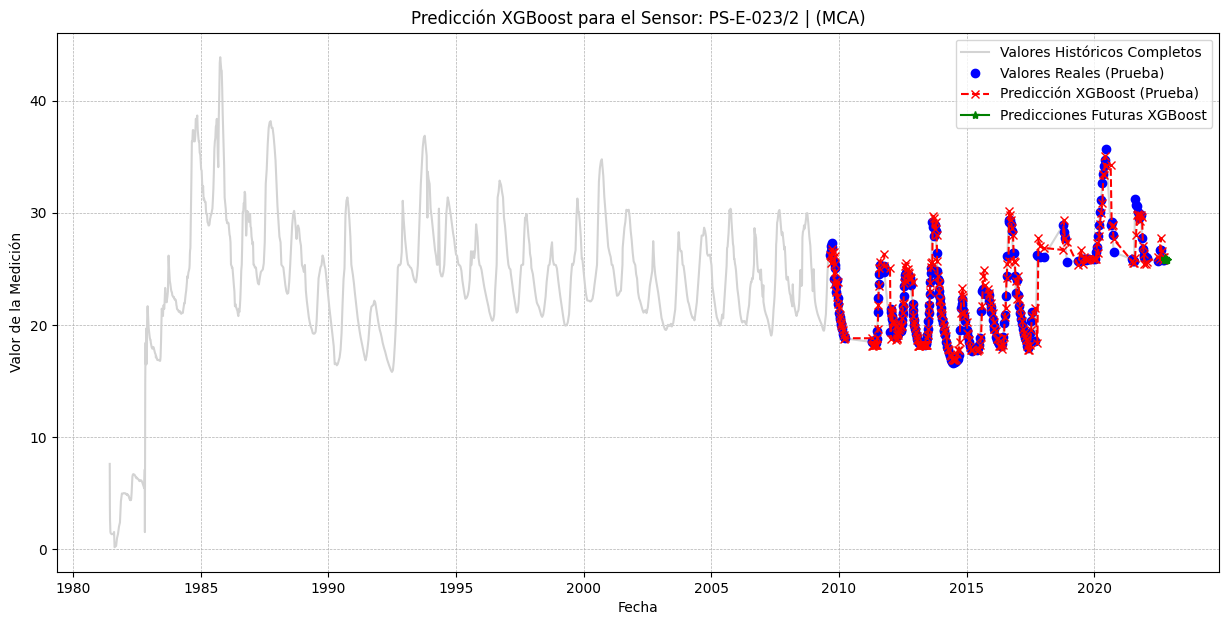

In [6]:
# Hacer y desescalar predicciones para el conjunto de prueba usando el modelo XGBoost entrenado
predictions_scaled_xgb = xgb_model.predict(X_test_xgb)
predictions_xgb = scaler.inverse_transform(predictions_scaled_xgb.reshape(-1, 1))

# Transformación inversa de los valores reales de prueba para XGBoost
y_test_real = scaler.inverse_transform(y_test_xgb.reshape(-1, 1))


# Visualización

# Determinar las fechas para el conjunto de prueba y las predicciones futuras
# El conjunto de prueba para XGBoost (X_test_xgb, y_test_xgb) comienza después del conjunto de entrenamiento (X_train_xgb, y_train_xgb).
# El punto de división en los arrays X_xgb, y_xgb es split_point_xgb.
# X_xgb fue creado a partir de scaled_data usando una ventana deslizante de sequence_length.
# La i-ésima fila de X_xgb corresponde a scaled_data[i:i+sequence_length].
# El i-ésimo elemento de y_xgb corresponde a scaled_data[i+sequence_length, 0].
# El primer elemento de y_xgb corresponde a scaled_data[sequence_length, 0].
# El punto de división en X_xgb, y_xgb es split_point_xgb.
# El primer elemento de y_test_xgb es y_xgb[split_point_xgb], que corresponde a scaled_data[split_point_xgb + sequence_length, 0].
# Por lo tanto, las fechas para y_test_xgb (y predictions_xgb) deben comenzar desde el índice (split_point_xgb + sequence_length) en el índice original de df_sensor.

start_index_test_data_xgb = split_point_xgb + sequence_length

# Obtener las fechas para el conjunto de prueba del índice original de df_sensor
test_dates_xgb = df_sensor.index[start_index_test_data_xgb:]

# Determinar la fecha de inicio de las predicciones futuras
# Las predicciones futuras comienzan después de la última fecha histórica en df_sensor
last_historical_date = df_sensor.index[-1]
# Asumir que la frecuencia es la misma que la última frecuencia observada en el índice de df_sensor
# Si la frecuencia no está configurada o es irregular, usar days=1 podría ser un valor predeterminado razonable,
# pero usar la frecuencia real del índice original es más preciso si está disponible.
# Comprobar si df_sensor.index tiene una frecuencia
if df_sensor.index.freq is not None:
    future_dates_xgb = pd.date_range(start=last_historical_date + df_sensor.index.freq, periods=num_future_steps, freq=df_sensor.index.freq)
else:
    # Si la frecuencia no está disponible, intentar inferirla o usar un valor predeterminado como diario
    # Para este conjunto de datos, la frecuencia parece irregular, así que generemos fechas comenzando el día después de la última fecha histórica
    future_dates_xgb = pd.date_range(start=last_historical_date + pd.Timedelta(days=1), periods=num_future_steps) # Por defecto a diario si freq es None


plt.figure(figsize=(15, 7))
plt.plot(df_sensor.index, df_sensor['valor_promedio'], label='Valores Históricos Completos', color='lightgray')
plt.plot(test_dates_xgb, y_test_real, label='Valores Reales (Prueba)', color='blue', marker='o', linestyle='None')
plt.plot(test_dates_xgb, predictions_xgb, label='Predicción XGBoost (Prueba)', color='red', marker='x', linestyle='--') # Añadir predicciones de prueba de XGBoost
plt.plot(future_dates_xgb, future_predictions_xgb, label='Predicciones Futuras XGBoost', color='green', marker='*', linestyle='-') # Añadir predicciones futuras de XGBoost

plt.title(f'Predicción XGBoost para el Sensor: {sensor_tag}')
plt.xlabel('Fecha')
plt.ylabel('Valor de la Medición')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

## Evaluar el modelo xgboost

Asegurarse de que las celdas de evaluación (MSE, RMSE, MAE, R2) funcionen correctamente con las predicciones del modelo XGBoost.

Se requiere calcular e imprimir las métricas de evaluación (MSE, RMSE, MAE, R2) para el modelo XGBoost utilizando los valores reales de prueba (`y_test_real`) y las predicciones de XGBoost (`predictions_xgb`). Esto implica utilizar las funciones `mean_squared_error`, `mean_absolute_error` y `r2_score` de `sklearn.metrics` y la función `sqrt` de `math`. Estas librerías ya están importadas. El código calculará estas métricas y luego las imprimirá junto con la etiqueta del sensor.

In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

# Calcular métricas de evaluación para XGBoost

# Calcular métricas de evaluación
mse_xgb = mean_squared_error(y_test_real, predictions_xgb)
rmse_xgb = sqrt(mse_xgb)
mae_xgb = mean_absolute_error(y_test_real, predictions_xgb)
r2_xgb = r2_score(y_test_real, predictions_xgb)

print(f"Evaluación del Modelo XGBoost para el Sensor: {sensor_tag}")
print(f"MSE: {mse_xgb:.4f}")
print(f"RMSE: {rmse_xgb:.4f}")
print(f"MAE: {mae_xgb:.4f}")
print(f"R2: {r2_xgb:.4f}")

Evaluación del Modelo XGBoost para el Sensor: PS-E-023/2 | (MCA)
MSE: 1.1618
RMSE: 1.0779
MAE: 0.6084
R2: 0.9272


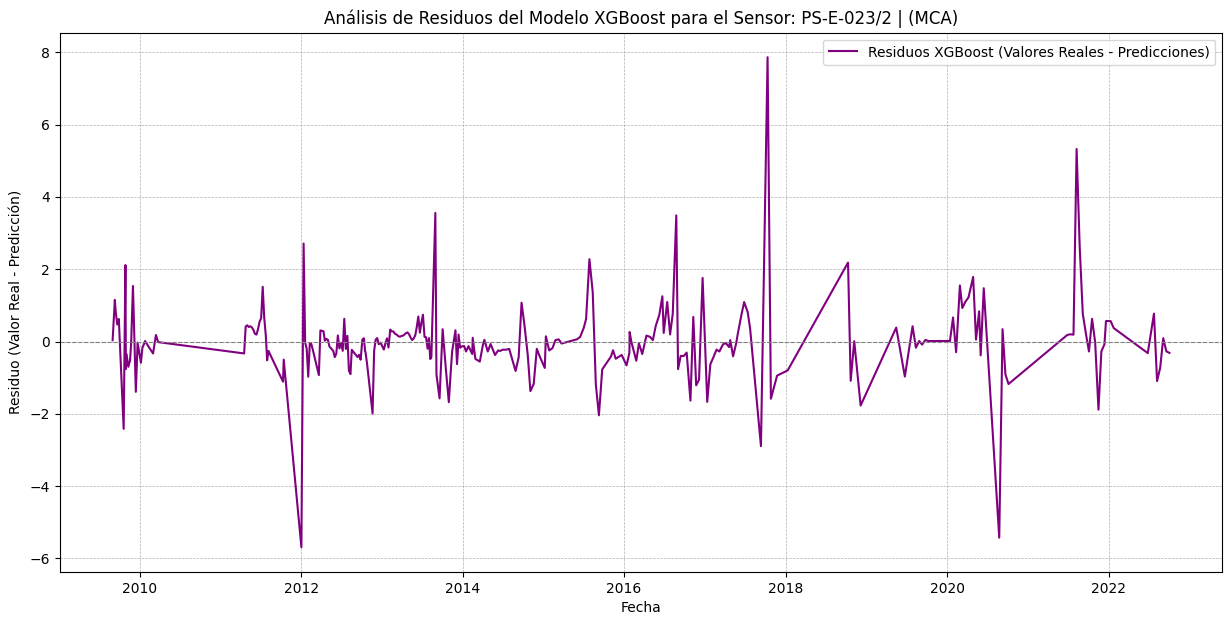


--- Fechas con Residuos Más Grandes (XGBoost) ---
Fecha con el residuo positivo más grande: 2017-10-11 (Residuo: 7.8619)
Fecha con el residuo negativo más grande: 2012-01-02 (Residuo: -5.6885)


In [8]:
# Analizar residuos

# Calcular residuos para XGBoost
residuals_xgb = y_test_real - predictions_xgb

# Visualización de residuos de XGBoost
plt.figure(figsize=(15, 7))
plt.plot(test_dates_xgb, residuals_xgb, label='Residuos XGBoost (Valores Reales - Predicciones)', color='purple')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8) # Añadir una línea horizontal en cero

plt.title(f'Análisis de Residuos del Modelo XGBoost para el Sensor: {sensor_tag}') # Título cambiado para reflejar XGBoost
plt.xlabel('Fecha')
plt.ylabel('Residuo (Valor Real - Predicción)')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

# Identificar fechas con los residuos positivos y negativos más grandes para XGBoost
largest_positive_residual_index_xgb = np.argmax(residuals_xgb)
largest_negative_residual_index_xgb = np.argmin(residuals_xgb)

date_largest_positive_xgb = test_dates_xgb[largest_positive_residual_index_xgb]
value_largest_positive_xgb = residuals_xgb[largest_positive_residual_index_xgb]

date_largest_negative_xgb = test_dates_xgb[largest_negative_residual_index_xgb]
value_largest_negative_xgb = residuals_xgb[largest_negative_residual_index_xgb]

print(f"\n--- Fechas con Residuos Más Grandes (XGBoost) ---")
print(f"Fecha con el residuo positivo más grande: {date_largest_positive_xgb.strftime('%Y-%m-%d')} (Residuo: {value_largest_positive_xgb[0]:.4f})")
print(f"Fecha con el residuo negativo más grande: {date_largest_negative_xgb.strftime('%Y-%m-%d')} (Residuo: {value_largest_negative_xgb[0]:.4f})")

In [9]:
# Guardar el modelo entrenado XGBoost
import joblib

model_save_path_xgb = 'xgboost_sensor_model.joblib'
joblib.dump(xgb_model, model_save_path_xgb)

print(f"\n--- Modelo XGBoost guardado exitosamente ---")
print(f"Ruta del archivo: {model_save_path_xgb}")


--- Modelo XGBoost guardado exitosamente ---
Ruta del archivo: xgboost_sensor_model.joblib


## Resumen:

### Hallazgos clave del análisis de datos

1. La preparación de los datos se adaptó con éxito para XGBoost implementando una función `create_features_xgb` que utiliza una ventana deslizante de `sequence_length` (por defecto 6) para crear características a partir de valores pasados, adecuada para el requisito de entrada no secuencial de XGBoost. Los datos escalados se transformaron en arrays `X_xgb` y `y_xgb`, que luego se dividieron en conjuntos cronológicos de entrenamiento y prueba.
2. Se construyó y entrenó con éxito un modelo `XGBRegressor` utilizando los datos preparados `X_train_xgb` y `y_train_xgb`. Se utilizaron hiperparámetros comunes como `n_estimators`, `learning_rate` y `max_depth`, con un `random_state` establecido para la reproducibilidad.
3. Las predicciones futuras para `num_future_steps` (por defecto 30) se generaron de forma iterativa utilizando el modelo XGBoost entrenado. Las predicciones del modelo se retroalimentaron en la secuencia de entrada para las predicciones subsiguientes. Las predicciones futuras escaladas se transformaron inversamente con éxito a la escala original.
4. El proceso de visualización se modificó con éxito para graficar los datos históricos completos, los valores reales para el conjunto de prueba (`y_test_real`), las predicciones del modelo XGBoost en el conjunto de prueba (`predictions_xgb`) y las predicciones futuras generadas (`future_predictions_xgb`). Las fechas para el conjunto de prueba y las predicciones futuras se determinaron y alinearon correctamente con los datos.
5. Las métricas de evaluación (MSE, RMSE, MAE, R2) se calcularon con éxito para el modelo XGBoost comparando los valores reales de prueba (`y_test_real`) con las predicciones de XGBoost en el conjunto de prueba (`predictions_xgb`).
6. El análisis de residuos se realizó con éxito para el modelo XGBoost. Los residuos se calcularon, se graficaron a lo largo del tiempo y se identificaron y reportaron las fechas con los residuos positivos y negativos más grandes.
7. El modelo XGBoost entrenado se guardó con éxito en un archivo llamado `xgboost_sensor_model.joblib` utilizando la librería `joblib`.

